In [1]:
import os, sys, re
from itertools import islice 
import numpy as np
import pandas as pd
import hashlib
import random
import math
import json
from random import sample
from tqdm import tqdm
import IPython
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

In [2]:
#keywords = ['people', 'something', 'little', 'hundred', 'important', 'problem', 'million', 
#            'technology', 'africa', 'science', 'community', 'government', 'challenge', 'major', 
#            'organization', 'london', 'washington', 'japanese', 'nigeria', 'england', 'germany',
#            'ingredients', 'rose', 'benjamin', 'kevin']

In [5]:
#non_keywords = ['outside', 'different', 'information', 'service', 
#                'seen', 'everything', 'collection', 'courses', 'insurance', 'issue', 
#                'bank', 'continue', 'specific', 'best', 'watch', 'report', 'cost','back', 
#                'was', 'here', 'their', 'will', 'went', 'have', 'what', 'which', 'with','that', 'this']


### Prepare data and compute features

In [2]:
words_1000 = [] 
with open('1000-midlong', 'r') as thousend_words:
    for word in thousend_words:
        words_1000.append(word.strip())

In [3]:
#'percent',  'today'
#keywords = ['world', 'people', 'fact', 'point']
keywords = ['percent', 'world', 'today', 'people', 'last', 'another', 'change', 'should', 'sort', 'find', 'after', 'fact']

In [4]:
possible_non_keywords = list(set(words_1000) - set(keywords))

For the non keywords, we sample randomly 250 words from the database and limit the number of samples to one thousand per word.

In [5]:
non_keywords = sample(possible_non_keywords, k=500)

In [6]:
#path = os.path.abspath("../../Datasets/TEDLIUM_release1/idiap_kw_db/")
path = os.path.abspath("../../Datasets/TEDLIUM_release1/1000_words_1sec/")
path_kw = os.path.abspath("../../Datasets/TEDLIUM_release1/initial_eval_set/")
filenames = []

#for w in (keywords + non_keywords):
#    current_path = os.path.join(path, w[0], w) 
#    for _, _, files in os.walk(current_path):
#        if w in non_keywords:
#            if len(files)>1000:
#                files = sample(files, k=1000)
#        for file in files:
#            filenames.append(os.path.join(current_path, file))
            
for w in keywords:
    current_path = os.path.join(path_kw, w[0], w) 
    for _, _, files in os.walk(current_path):
        for file in files:
            filenames.append(os.path.join(current_path, file))
            
for w in non_keywords:
    current_path = os.path.join(path, w[0], w) 
    for _, _, files in os.walk(current_path):
        if len(files)>1000:
            files = sample(files, k=1000)
        for file in files:
            filenames.append(os.path.join(current_path, file))

We load the .wav file and trim it to have **1 second long word** (append with zeros if signal length is less than 1 second). We compute **40 MFCC features** for each word. 

In [7]:
num_features = 40

In [8]:
def augment_with_noise(signal, noise_factor=1.0):
    noise = np.random.randn(len(signal))
    augmented_data = signal + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(signal[0]))
    return augmented_data


def compute_mfcc(signal, fs, threshold=1.0, num_features=40, add_noise=True): 
    
    dur = len(signal)
    if dur < int(threshold * fs):
        zeros = np.zeros((int(threshold * fs) - dur, 1)).reshape(-1,)
        signal = np.concatenate((signal, zeros), axis=0)
    else:
        signal = signal[:int(threshold * fs)]
    
    features = mfcc(signal, samplerate=fs, winlen=0.030, winstep=0.01, numcep=num_features,
                    lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=num_features)
    
    if add_noise:
        noisy_signal = augment_with_noise(signal, noise_factor=1.0)
        noisy_features = mfcc(noisy_signal, samplerate=fs, winlen=0.030, winstep=0.01, numcep=num_features,
                    lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=num_features)
        
        return features, noisy_features
    else:
        return features

In [9]:
fs, sig = wav.read(filenames[10])
xdim, _ = compute_mfcc(sig, fs, threshold=1.0, num_features=40, add_noise=False).shape

**Function to split the dataset into training, testing and validation**

In [10]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    """
    Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_.' in a filename is
    ignored for set determination. This ensures that 'AdamSavage_2008P_5.wav' and
    'AdamSavage_2008P_0.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    
    kw = filename.split('/')[-2]
    base_name = kw + '-' + os.path.basename(filename).replace('_', '-', 1)
    # We want to ignore anything after '-' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

In [11]:
kw = filenames[0].split('/')[-2]
base_name = kw + '-' + os.path.basename(filenames[0]).replace('_', '-', 1)
hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')

In [12]:
hash_name

b'percent-HansRosling-2010S'

**Compute features for the training, testing and validation sets**

In [13]:
def generate_sets(filenames, validation_percentage=10, testing_percentage=10, add_noise=True):
    
    non_keywords_label = len(keywords)

    training, validation, testing = [], [], []

    for filename in tqdm(filenames, position=0, leave=True):
        _, signal = wav.read(filename)
        kw = filename.split('/')[-2]

        if add_noise and (kw in keywords):
            feats, noisy_feats = compute_mfcc(signal, fs=16000, threshold=1.0, num_features=40, add_noise=add_noise)
        else:
            feats = compute_mfcc(signal, fs=16000, threshold=1.0, num_features=40, add_noise=False)
                            
        if kw in keywords:
            label = keywords.index(kw)
        else:
            label = non_keywords_label
            
        grp = which_set(filename, validation_percentage, testing_percentage)
        
        if grp is 'training':
            training.append((feats, label))
            if add_noise and (kw in keywords):
                training.append((noisy_feats, label))
        elif grp is 'validation' :
            validation.append((feats, label))
            if add_noise and (kw in keywords):
                validation.append((noisy_feats, label))            
        else:
            testing.append((feats, label))
            if add_noise and (kw in keywords):
                testing.append((noisy_feats, label))            
    
    return training, validation, testing

In [14]:
training, validation, testing = generate_sets(filenames, validation_percentage=10, testing_percentage=10, add_noise=False)

100%|██████████| 209502/209502 [07:48<00:00, 447.03it/s]


**Shape features in correct format or models to train on**

In [15]:
def get_X_y(grp, xdim, num_features=40):
    X, y = zip(*grp)
    X = list(map(lambda x: x.reshape(xdim, num_features, 1), X))
    return np.array(X).reshape(-1, xdim, num_features, 1), np.array(y).reshape(-1,1)

### Train model

In [17]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, AveragePooling2D, Dense, Flatten, Input, Add, Lambda
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

**We define 2 architectures: a deep CNN and a Residual network**

In [18]:
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    P = precision(y_true, y_pred)
    R = recall(y_true, y_pred)
    return 2*((P*R)/(P+R+K.epsilon()))

In [19]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed


def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

In [21]:
def res_net():
    
    input_data = Input(shape=(xdim, num_features, 1))
    l = 0
    for i in range(6):
        if i == 0:
            x = Conv2D(45, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform')(input_data)
            x = BatchNormalization(axis=-1)(x)
            l += 1
            x = Conv2D(45, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(x)
            l += 1
            x = BatchNormalization(axis=-1)(x)
            
        else:
            y = Conv2D(45, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(x)
            y = BatchNormalization(axis=-1)(y)
            l += 1
            y = Conv2D(45, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(y)
            l += 1
            y = BatchNormalization(axis=-1)(y)
            
            y = Add()([y, x])
            x = Lambda(lambda x: x)(y)


    x = AveragePooling2D(pool_size=(2,2),data_format='channels_last')(x)
    x = Flatten()(x)
    x = Dense(units=len(keywords) + 1, activation='softmax')(x)
    
    model = Model(inputs=input_data, outputs=x) 
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    
    return model

def dnn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(xdim, num_features, 1), data_format='channels_last')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size=(3,5), activation='relu')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(5,5), activation='relu')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    #model.add(Conv2D(256, kernel_size=(5,5), activation='relu')) 
    #model.add(BatchNormalization(axis=-1))
    #model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=len(keywords) + 1, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
X_train, y_train = get_X_y(training, xdim=xdim, num_features=40)
X_validation, y_validation = get_X_y(validation, xdim=xdim, num_features=40)
y_train, y_validation = to_categorical(y_train), to_categorical(y_validation)

In [23]:
#model = dnn_model()
model = res_net()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 98, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 40, 45)   450         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 40, 45)   180         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 40, 45)   18270       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [292]:
#class_weights = {0: 0.95,
#                1: 0.05}

In [24]:
model.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_validation, y_validation))

Train on 166927 samples, validate on 20872 samples
Epoch 1/1
166927/166927 [==============================] - 419s 3ms/step - loss: 1.6118 - acc: 0.5954 - val_loss: 1.2711 - val_acc: 0.6061


In [25]:
model.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_validation, y_validation))

Train on 166927 samples, validate on 20872 samples
Epoch 1/1
166927/166927 [==============================] - 403s 2ms/step - loss: 0.8976 - acc: 0.7237 - val_loss: 1.1109 - val_acc: 0.6821


In [31]:
model.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_validation, y_validation))

Train on 166927 samples, validate on 20872 samples
Epoch 1/1
166927/166927 [==============================] - 402s 2ms/step - loss: 0.6237 - acc: 0.7985 - val_loss: 1.0825 - val_acc: 0.6961


### Evaluate model 

In [32]:
X_test, y_test = get_X_y(testing, xdim=xdim, num_features=40)
y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1).reshape(-1,1)

21703/21703 [==============================] - 20s 923us/step


In [27]:
def accuracy_per_label(y_true, y_pred, label):
    y_true_label = y_true[y_true == label]
    y_pred = y_pred[y_true == label]
    n_samples = len(y_pred)
    return n_samples, accuracy_score(y_true_label, y_pred)

In [33]:
accuracies_per_label = []

for i in range(len(keywords) + 1):
    n, acc = accuracy_per_label(y_test, y_pred, label=i)
    if i < len(keywords):
        accuracies_per_label.append((n, acc, keywords[i]))
    else:
        accuracies_per_label.append((n, acc, 'non_keyword'))

In [30]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[1], reverse=True)
accuracies_per_label

[(12351, 0.8742611934256336, 'non_keyword'),
 (1515, 0.7128712871287128, 'world'),
 (3177, 0.5945860875039345, 'people'),
 (405, 0.48148148148148145, 'change'),
 (460, 0.29347826086956524, 'percent'),
 (605, 0.2512396694214876, 'fact'),
 (460, 0.18695652173913044, 'today'),
 (450, 0.18444444444444444, 'another'),
 (425, 0.14352941176470588, 'last'),
 (610, 0.11311475409836065, 'find'),
 (375, 0.09866666666666667, 'should'),
 (560, 0.09107142857142857, 'sort'),
 (310, 0.05806451612903226, 'after')]

In [34]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[0], reverse=True)
accuracies_per_label

[(12351, 0.8909400048579063, 'non_keyword'),
 (3177, 0.5618508026440038, 'people'),
 (1515, 0.6772277227722773, 'world'),
 (610, 0.23934426229508196, 'find'),
 (605, 0.12892561983471074, 'fact'),
 (560, 0.16607142857142856, 'sort'),
 (460, 0.35434782608695653, 'percent'),
 (460, 0.3, 'today'),
 (450, 0.25555555555555554, 'another'),
 (425, 0.25882352941176473, 'last'),
 (405, 0.47901234567901235, 'change'),
 (375, 0.09066666666666667, 'should'),
 (310, 0.11290322580645161, 'after')]

In [89]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[0], reverse=True)
accuracies_per_label

[(8140, 0.9217444717444717, 'non_keyword'),
 (3177, 0.6971986150456405, 'people'),
 (1515, 0.732013201320132, 'world'),
 (460, 0.26521739130434785, 'percent'),
 (460, 0.4152173913043478, 'today')]

In [35]:
def generate_windows(signal, fs, window_dur=1.0, shift=0.3):
    windows = []
    window_size = int(window_dur * fs)
    current_index = 0 
    end_sentence = False
    signal_duration = len(signal)

    while not end_sentence:
        if current_index + window_size < signal_duration:
            windows.append(signal[current_index:current_index + window_size])
            current_index += int(shift * fs)
        else:
            windows.append(signal[-window_size:])
            end_sentence = True
    return windows

def compute_mfcc_frames(signal, fs, shift=0.3, num_features=40):
    
    windows = generate_windows(signal, fs=fs, shift=shift)
    frames = []
    
    for window in windows:
        frame = mfcc(window, samplerate=16000, winlen=0.030, winstep=0.01, numcep=40, 
                     lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=40)
        frames.append(frame)
    return np.array(frames).reshape(-1, xdim, num_features, 1)


In [36]:
def create_file(path2dataset='/aimlx/Datasets/TEDLIUM_release1/'):
    file_partition = []
    
    current_path = os.path.join(path2dataset, 'dev', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('dev',  os.path.join(current_path,file)))

    current_path = os.path.join(path2dataset, 'test', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('test',  os.path.join(current_path,file)))

    current_path = os.path.join(path2dataset, 'train', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('train', os.path.join(current_path,file)))                

    #pickle.dump(file_partition, fp)
    return file_partition

In [37]:
def produce_groundTruth_labels(sentence, keyword, start_kw, end_kw, fs=16000, window_dur=1.0, shift=0.1, percentage_kw=0.8):
    gt_labels = []    
    window_size = int(window_dur * fs)
    current_index = 0 
    end_sentence = False
    signal_duration = len(sentence)
    nb_samples_kw = int(end_kw * fs) - int(start_kw * fs) 
    label_kw = keywords.index(keyword)
    label_non_kw = len(keywords) 
    
    while not end_sentence:
        if current_index + window_size < signal_duration:
            if (current_index + window_size < start_kw * fs) or (current_index > end_kw * fs):
                gt_labels.append(label_non_kw)
            else:
                beg_kw_window = max(current_index, int(start_kw * fs))
                end_kw_window = min(current_index + window_size, int(end_kw * fs))
                kw_samples_in_window = end_kw_window - beg_kw_window
                
                if kw_samples_in_window / nb_samples_kw < percentage_kw:
                    gt_labels.append(label_non_kw)
                else:
                    gt_labels.append(label_kw)
            current_index += int(shift * fs)
        else:
            if int(end_kw * fs) < signal_duration - window_size:
                gt_labels.append(label_non_kw)
            elif int(start_kw * fs) > signal_duration - window_size:
                gt_labels.append(label_kw)
            else:
                kw_samples_in_window = int(end_kw * fs) - (signal_duration - window_size) 
                
                if kw_samples_in_window / nb_samples_kw < percentage_kw:
                    gt_labels.append(label_non_kw)
                else:
                    gt_labels.append(label_kw)                
                
            end_sentence = True
            
    return np.array(gt_labels)

In [44]:
def extract_sentence(path2wav_file, path2dataset, file_partition, duration=5, shift=0.1, percentage_kw=1.0):
    filename = path2wav_file.split('/')[-1]
    occurence = int(filename.split('_')[-1].split('*')[0])
    filename = '_'.join(filename.split('_')[:2])
    keyword = path2wav_file.split('/')[-2]
    
    filtered_list = list(filter(lambda x: filename in x[1], file_partition))[0]
    partition = filtered_list[0]
    path2wav_talk = filtered_list[1]
        
    path2json = os.path.join(path2dataset, partition, 'final_json', filename + '.json')
    with open(path2json) as json_file:
        data = json.load(json_file)
        count = -1 
        for word in data['words']:
            if partition == 'train':
                word = data['words'][word]
            if not word['case'] == 'not-found-in-audio' and (word['alignedWord'] == keyword):
                count += 1
            if count == occurence:
                start_kw, end_kw = word['start'], word['end']
                break

    if start_kw - duration/2.0 < 0:
        start_sentence = 0
        end_sentence = duration - end_kw
    else:
        start_sentence = start_kw - duration/2.0
        end_sentence = end_kw + duration/2.0
        
    fs, signal = wav.read(path2wav_talk)
    start_signal, end_signal = int(start_sentence * fs), int(end_sentence * fs)
    sentence = signal[start_signal:end_signal]
    
    y_test = produce_groundTruth_labels(sentence, keyword=keyword, start_kw=start_kw-start_sentence, end_kw=start_kw-start_sentence + (end_kw -start_kw), 
                                        fs=fs, shift=shift, percentage_kw=percentage_kw)
    
    return fs, sentence, y_test

In [130]:
test_files = []
for file in filenames:
    grp = which_set(file, validation_percentage=10, testing_percentage=10)
    if grp is 'testing':
        if any(kw in file for kw in keywords):
            test_files.append(file)

In [342]:
test_files_iterator = iter(test_files)

In [338]:
file_partition = create_file()
fs, sentence, y_test = extract_sentence(path2wav_file=random.sample(test_files,k=1)[0], path2dataset='/aimlx/Datasets/TEDLIUM_release1/',
                                        file_partition=file_partition, duration=5, shift=0.25, percentage_kw=1.0)

IPython.display.Audio(sentence, rate=fs)

In [339]:
y_test

array([4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4])

19/19 [==============================] - 0s 167us/step


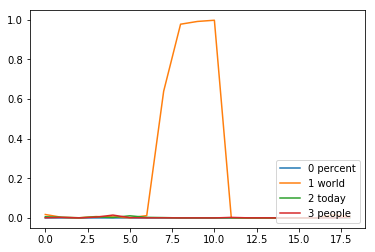

In [340]:
frames = compute_mfcc_frames(sentence, fs, shift=0.25, num_features=40)
y_pred = model.predict_proba(frames, verbose=1)
plt.plot(y_pred[:,0], label='0 ' + keywords[0])
plt.plot(y_pred[:,1], label='1 ' + keywords[1])
plt.plot(y_pred[:,2], label='2 ' + keywords[2])
plt.plot(y_pred[:,3], label='3 ' + keywords[3])
plt.legend(loc="lower right")

In [341]:
np.argmax(y_pred, axis=1)

array([4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4])

In [228]:
sum(y_test==3)/len(y_test)

0.15555555555555556

In [88]:
# precision recall curve
temp = label_binarize(y_test, classes=range(len(keywords) + 1))
precision, recall, _ = precision_recall_curve(temp[:, 3],y_pred[:, 3])
plt.plot(recall, precision, lw=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()

NameError: name 'label_binarize' is not defined

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from scipy import interp
from sklearn.preprocessing import label_binarize

**ROC AUC**

100%|██████████| 1123/1123 [17:47<00:00,  1.05it/s]
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


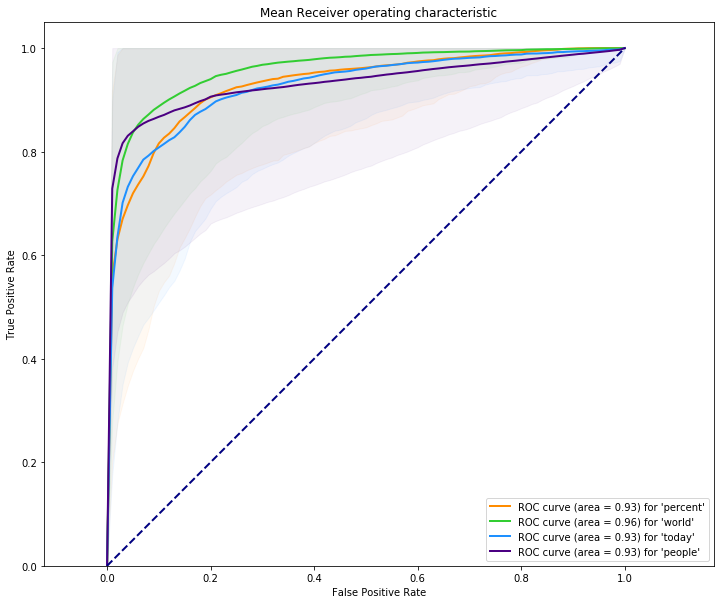

In [138]:
#tprs = []
tprs = dict()
base_fpr = np.linspace(0, 1, 101)
auc_scores = []
file_partition = create_file()
plt.figure(figsize=(12, 10))
error_files = []
classes = range(len(keywords) + 1)
fpr, tpr, auc_scores = dict(), dict(), dict()
colors = ['darkorange', 'limegreen', 'dodgerblue', 'indigo', 'red', 'dimgray']

#test_files[:5] + test_files[-5:] + test_files[100:105] + test_files[415:420]

for file in tqdm(test_files, position=0, leave=True):
    try:
        fs, sentence, y_test = extract_sentence(path2wav_file=file, path2dataset='/aimlx/Datasets/TEDLIUM_release1/',
                                                file_partition=file_partition, duration=5, shift=0.01, percentage_kw=1.0)
        
        keyword = file.split('/')[-2]
        idx = keywords.index(keyword)
        
        y_test = label_binarize(y_test, classes=classes)
        frames = compute_mfcc_frames(sentence, fs, shift=0.01, num_features=40)
        y_pred = model.predict_proba(frames)

        fpr, tpr, _ = roc_curve(y_test[:, idx], y_pred[:, idx])
        auc_score = auc(fpr, tpr)
        if idx not in auc_scores:
            #fpr[idx] = [fpr]
            #tpr[idx] = [tpr]
            auc_scores[idx] = [auc_score]
        else:
            #fpr[idx].append(fpr)
            #tpr[idx].append(tpr)
            auc_scores[idx].append(auc_score)           
            
        #plt.plot(fpr, tpr, 'darkorange', alpha=0.05)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        if idx not in tprs:
            tprs[idx] = [tpr]
        else:
            tprs[idx].append(tpr)
        
    except IndexError as error:
        error_files.append(file)
        
for idx in tprs.keys():
    tprs[idx] = np.array(tprs[idx])
    mean_tprs = tprs[idx].mean(axis=0)
    std = tprs[idx].std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.plot(base_fpr, mean_tprs, colors[idx], lw=2, label='ROC curve (area = %0.2f) for \'%s\'' % (np.mean(np.array(auc_scores[idx])), keywords[idx])) 
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=0.05)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.title('Mean Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

**Precision-Recall curve**

ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

Davis and Goadrich in this [paper](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/davis.icml06.pdf) propose that Precision-Recall (PR) curves will be more informative than ROC when dealing with highly skewed datasets. The PR curves plot precision vs. recall (FPR). Because Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets. When you compare different models with imbalanced settings, the area under the Precision-Recall curve will be more sensitive than the area under the ROC curve